# Programming Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Fall 2019

### Part I: Stitch two key frames <img src="images/project_5/image005.jpg" alt="Drawing" style="float: right; width: 450px"/>

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.



Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image, like this:
<p>
    <img src="images/project_5/image002.jpg" alt="Drawing"/>
    <img src="images/project_5/image004.jpg" alt="Drawing"/>
</p>

In [1]:
import cv2
import numpy as np
from numpy.linalg import svd, inv

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

In [3]:
def auto_homography(Ia,Ib, homography_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, 4, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2) # edit helper code below (computeHomography)

        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        du = Xb_[0,:]/Xb_[2,:] - Xb[0,:]/Xb[2,:]
        dv = Xb_[1,:]/Xb_[2,:] - Xb[1,:]/Xb[2,:]
        
        ok_t = np.sqrt(du**2 + dv**2) < 0.67  # you may need to play with this threshold
        score_t = sum(ok_t)

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = ok_t
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [4]:
def computeHomography(pts1, pts2):
    '''
    Compute homography that maps from pts1 to pts2 using least squares solver
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    N = pts1.shape[1]
    
    print(pts1)
        
    A = np.zeros((2*N, 9))
    for i in range(N):
        A[2*i,:] = [-pts1[0,i],-pts1[1,i],-1,0,0,0,pts1[0,i]*pts2[0,i],pts1[1,i]*pts2[0,i],pts2[0,i]]
        A[2*i+1,:] = [0,0,0,-pts1[0,i],-pts1[1,i],-1,pts1[0,i]*pts2[1,i],pts1[1,i]*pts2[1,i],pts2[1,i]]
    
    H,S,V = svd(A)
    h = V[-1,:]
    
    H = np.reshape(h,(3,3))
    
    return H


In [5]:
H = auto_homography(im1,im2, computeHomography)

# print(H)

[[409.02578735 244.46450806 273.8927002  437.03503418]
 [ 37.9750061  115.43370819 176.79653931  47.99398804]
 [  1.           1.           1.           1.        ]]
[[377.19619751 402.10964966 348.34970093 466.97558594]
 [ 58.25606918 164.88912964 171.99549866 149.27885437]
 [  1.           1.           1.           1.        ]]
[[360.88259888 276.73059082 232.52627563 310.57000732]
 [ 90.74619293 113.9151001  110.09842682 145.33721924]
 [  1.           1.           1.           1.        ]]
[[313.74267578 272.66253662 344.00030518 237.0014801 ]
 [129.02122498 138.07252502 104.20468903  98.94570923]
 [  1.           1.           1.           1.        ]]
[[447.70828247 280.47290039 327.13122559 216.07868958]
 [ 58.11839294 164.43147278  82.20689392  42.16764069]
 [  1.           1.           1.           1.        ]]
[[336.36938477 410.5574646  449.85140991 399.5418396 ]
 [121.49658966 167.06307983  80.01701355 186.03068542]
 [  1.           1.           1.           1.        ]]
[[33

[[428.13128662 460.73687744 442.47415161 132.03112793]
 [120.80561829  34.63751221  78.68144226 301.59741211]
 [  1.           1.           1.           1.        ]]
[[399.5418396  304.97839355 235.74354553 218.9770813 ]
 [186.03068542  74.91812897 134.914505    52.12050629]
 [  1.           1.           1.           1.        ]]
[[ 86.90619659  56.71710205 325.81091309 359.44924927]
 [201.48292542 238.90296936 182.25456238 104.20819092]
 [  1.           1.           1.           1.        ]]
[[257.19467163 254.62176514 271.90286255 296.90078735]
 [341.67877197 338.33731079  42.57689285 195.60490417]
 [  1.           1.           1.           1.        ]]
[[224.98257446 326.47271729 365.92068481 300.381073  ]
 [166.677948    91.38494873  60.65895462 161.69711304]
 [  1.           1.           1.           1.        ]]
[[380.44299316 361.86004639 282.98864746 328.56417847]
 [117.8577652  105.32761383  97.4342041  123.73011017]
 [  1.           1.           1.           1.        ]]
[[23

 [  1.           1.           1.           1.        ]]
[[311.26373291 313.80215454 214.40411377 299.31436157]
 [168.05108643 190.65342712 274.07006836 125.95594025]
 [  1.           1.           1.           1.        ]]
[[313.56048584 313.74267578 300.381073   237.43341064]
 [199.68797302 129.02122498 161.69711304  83.46352386]
 [  1.           1.           1.           1.        ]]
[[235.79272461 442.47415161 417.04516602 410.95278931]
 [153.67964172  78.68144226  54.51306915 155.41921997]
 [  1.           1.           1.           1.        ]]
[[207.90835571 333.32714844 376.55841064 325.81091309]
 [ 28.68311119 118.42102814 157.08811951 182.25456238]
 [  1.           1.           1.           1.        ]]
[[145.25012207 398.72097778 449.85140991 225.03596497]
 [ 41.82926559  51.64969254  80.01701355  78.10041046]
 [  1.           1.           1.           1.        ]]
[[247.19619751 257.19467163 445.82559204 442.47415161]
 [108.71186829 341.67877197 158.34841919  78.68144226]
 [  

 [  1.           1.           1.           1.        ]]
[[449.85140991 254.62176514 376.15921021 448.89703369]
 [ 80.01701355 338.33731079 122.93087769 164.88371277]
 [  1.           1.           1.           1.        ]]
[[345.11834717 411.9954834  294.67138672 424.63793945]
 [100.2952652   60.84906769  24.28528404  54.44235229]
 [  1.           1.           1.           1.        ]]
[[254.62176514 218.58222961 376.20370483 457.88369751]
 [338.33731079  44.98974991  90.59210968 275.38638306]
 [  1.           1.           1.           1.        ]]
[[376.55841064 132.03112793 457.88369751 387.15652466]
 [157.08811951 301.59741211 275.38638306  33.33864212]
 [  1.           1.           1.           1.        ]]
[[363.52792358 280.47290039 454.49658203 446.22149658]
 [193.00236511 164.43147278  40.92245483 147.52990723]
 [  1.           1.           1.           1.        ]]
[[283.40631104 380.44299316 365.92068481 257.96115112]
 [163.22180176 117.8577652   60.65895462 333.96697998]
 [  

[[383.36886597 313.80215454 377.19619751 214.89317322]
 [123.53067017 190.65342712  58.25606918 171.57055664]
 [  1.           1.           1.           1.        ]]
[[433.99124146 435.04385376 312.30020142 276.73059082]
 [ 69.139534   128.26663208 181.40109253 113.9151001 ]
 [  1.           1.           1.           1.        ]]
[[292.5760498  327.13122559 383.36886597 257.16229248]
 [ 97.10736084  82.20689392 123.53067017 107.64780426]
 [  1.           1.           1.           1.        ]]
[[282.13150024  86.90619659 244.46450806 289.31390381]
 [149.10580444 201.48292542 115.43370819  42.02189636]
 [  1.           1.           1.           1.        ]]
[[383.36886597 223.19787598 427.92910767 235.55049133]
 [123.53067017 116.65673828 157.88938904 160.49363708]
 [  1.           1.           1.           1.        ]]
[[247.19619751 342.30581665 347.33233643 245.82049561]
 [108.71186829 174.82582092 181.12399292 154.21090698]
 [  1.           1.           1.           1.        ]]
[[21

[[454.76013184 357.35961914  66.92024994 312.30020142]
 [ 47.29360962 100.9626236  299.48034668 181.40109253]
 [  1.           1.           1.           1.        ]]
[[344.00030518 237.73106384 328.56417847 247.19619751]
 [104.20468903 111.74121094 123.73011017 108.71186829]
 [  1.           1.           1.           1.        ]]
[[454.38989258 216.54473877 208.90109253 359.44924927]
 [ 34.34231567 319.05612183 315.91018677 104.20819092]
 [  1.           1.           1.           1.        ]]
[[214.40411377 457.88369751 246.1129303  235.79272461]
 [274.07006836 275.38638306 146.253479   153.67964172]
 [  1.           1.           1.           1.        ]]
[[326.47271729 345.53292847 288.0670166  296.90078735]
 [ 91.38494873 161.86805725 114.43352509 195.60490417]
 [  1.           1.           1.           1.        ]]
[[460.73687744 280.35162354 367.43087769 427.92910767]
 [ 34.63751221 174.06790161 150.24029541 157.88938904]
 [  1.           1.           1.           1.        ]]
[[41

 [  1.           1.           1.           1.        ]]
[[400.51782227 235.79272461 411.67016602 212.59741211]
 [122.08329773 153.67964172  20.82270813 140.33616638]
 [  1.           1.           1.           1.        ]]
[[244.08900452 416.94952393 243.84840393 348.34970093]
 [165.84207153  66.22399902  99.71776581 171.99549866]
 [  1.           1.           1.           1.        ]]
[[345.11834717 462.82528687 226.57275391 390.27288818]
 [100.2952652  205.33711243 111.32239532 142.67961121]
 [  1.           1.           1.           1.        ]]
[[361.86004639 315.9083252  311.16467285 367.43087769]
 [105.32761383 182.24075317  60.32085419 150.24029541]
 [  1.           1.           1.           1.        ]]
[[313.80215454 144.56660461 402.64846802 462.82528687]
 [190.65342712  63.72525406 143.19839478 205.33711243]
 [  1.           1.           1.           1.        ]]
[[245.82049561 308.45397949 347.33233643 400.51782227]
 [154.21090698 113.82028961 181.12399292 122.08329773]
 [  

[[417.04516602 332.44165039 212.07115173 446.22149658]
 [ 54.51306915 186.48246765 163.66070557 147.52990723]
 [  1.           1.           1.           1.        ]]
[[327.13122559 249.71577454 220.08097839 468.15582275]
 [ 82.20689392 115.40498352  34.93755341 162.30595398]
 [  1.           1.           1.           1.        ]]
[[288.0670166  362.45437622 132.03112793 311.26373291]
 [114.43352509 116.62564087 301.59741211 168.05108643]
 [  1.           1.           1.           1.        ]]
[[315.32778931 357.35961914 437.03503418 209.01826477]
 [ 55.98298264 100.9626236   47.99398804 321.97775269]
 [  1.           1.           1.           1.        ]]
[[311.16467285 341.67001343 311.26373291 318.07592773]
 [ 60.32085419  81.93949127 168.05108643 171.04322815]
 [  1.           1.           1.           1.        ]]
[[348.11962891 411.67016602 282.04708862 460.38372803]
 [ 74.86380768  20.82270813 105.13887787 278.75546265]
 [  1.           1.           1.           1.        ]]
[[42

 [  1.           1.           1.           1.        ]]
[[410.95278931 399.5418396  132.03112793 362.45437622]
 [155.41921997 186.03068542 301.59741211 116.62564087]
 [  1.           1.           1.           1.        ]]
[[462.82528687 376.55841064 326.47271729 321.35150146]
 [205.33711243 157.08811951  91.38494873 166.83511353]
 [  1.           1.           1.           1.        ]]
[[209.01826477 223.37123108 243.84840393 377.19619751]
 [321.97775269 173.58891296  99.71776581  58.25606918]
 [  1.           1.           1.           1.        ]]
[[448.89703369 272.66253662 409.02578735 311.26373291]
 [164.88371277 138.07252502  37.9750061  168.05108643]
 [  1.           1.           1.           1.        ]]
[[340.8991394  317.92321777 237.73106384 357.35961914]
 [ 39.61338806  93.38191223 111.74121094 100.9626236 ]
 [  1.           1.           1.           1.        ]]
[[296.90078735 348.11962891 312.30020142 423.93518066]
 [195.60490417  74.86380768 181.40109253 163.14393616]
 [  

 [  1.           1.           1.           1.        ]]
[[348.34970093 235.68469238 296.65460205 226.57275391]
 [171.99549866 138.74736023 116.24333191 111.32239532]
 [  1.           1.           1.           1.        ]]
[[427.92910767 272.86251831 469.3633728  317.92321777]
 [157.88938904 148.38978577 109.95433807  93.38191223]
 [  1.           1.           1.           1.        ]]
[[292.5760498  310.57000732 469.3633728  283.40631104]
 [ 97.10736084 145.33721924 109.95433807 163.22180176]
 [  1.           1.           1.           1.        ]]
[[348.11962891 442.41021729  86.90619659 427.92910767]
 [ 74.86380768 164.72270203 201.48292542 157.88938904]
 [  1.           1.           1.           1.        ]]
[[282.04708862 273.8927002   86.90619659 294.67138672]
 [105.13887787 176.79653931 201.48292542  24.28528404]
 [  1.           1.           1.           1.        ]]
[[305.4859314  442.47415161 398.44619751 411.67016602]
 [105.77519226  78.68144226  57.93444443  20.82270813]
 [  

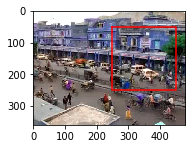

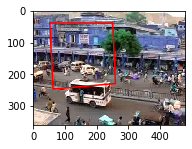

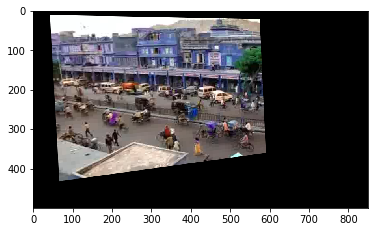

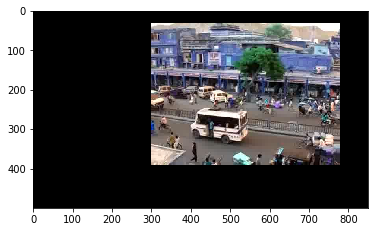

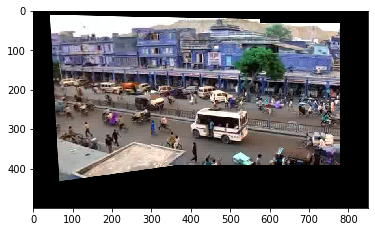

In [133]:
r1_i1 = 250
r1_j1 = 50
r1_i2, r1_j2 = r1_i1, r1_j1+200
r1_i3, r1_j3 = r1_i1+200, r1_j1+200
r1_i4, r1_j4 = r1_i1+200, r1_j1
r1_i5, r1_j5 = r1_i1, r1_j1

rp1_i = [r1_i1,r1_i2,r1_i3,r1_i4,r1_i5]
rp1_j = [r1_j1,r1_j2,r1_j3,r1_j4,r1_j5]

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
plt.imshow(im1)
ax1.plot(rp1_i, rp1_j, 'r')

rect1_proj = np.dot(H,[rp1_i,rp1_j,[1,1,1,1,1]])

rect1_proj /= rect1_proj[2]

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
plt.imshow(im2)
ax1.plot(rect1_proj[0].tolist(), rect1_proj[1].tolist(), 'r')


image_corners = [[0,0,len(im1[0]),len(im1[0])],[0,len(im1[1]),len(im1[1]),0],[1,1,1,1]]
corners_warped = np.dot(H, image_corners)
corners_warped /= corners_warped[2]

H_t = [[1,0,300],[0,1,30],[0,0,1]]
H_t2 = [[1,0,300],[0,1,30]]

img_warped = cv2.warpPerspective(im1, np.dot(H_t,H), (850, 500))
img_warped2 = cv2.warpAffine(im2, np.float32(H_t2), (850, 500))

plt.figure()
plt.imshow(img_warped)

plt.figure()
plt.imshow(img_warped2)

img_warped = np.float32(img_warped/255.0)
img_warped2 = np.float32(img_warped2/255.0)

canvas = np.zeros((img_warped.shape))
for i in range(500):
    for j in range(850):
#         if img_warped[i,j].any() and img_warped2[i,j].any():
#             canvas[i,j] = (img_warped[i,j]+img_warped2[i,j])/2
        if img_warped2[i,j].any():
            canvas[i,j] = img_warped2[i,j]
        elif img_warped[i,j].any():
            canvas[i,j] = img_warped[i,j]

# img_out = cv2.cvtColor(canvas,cv2.COLOR_RGB2BGR)
plt.figure()
plt.imshow(canvas)


### Part II: Panorama using five key frames

In this part you will produce a panorama using five key frames. Let's determine frames [90, 270, 450, 630, 810] as key frames. The goal is to map all the five frames onto the plane corresponding to frame 450 (that we also call the _reference frame_). For the frames 270 and 630 you can follow the instructions in part 1.

<img src="images/project_5/header.jpg" alt="Drawing" style="float: center; width: 500px"/>

Mapping frame 90 to frame 450 is difficult because they share very little area. Therefore you need to perform a two stage mapping by using frame 270 as a guide. Compute one projection from 90 to 270 and one from 270 to 450 and multiply the two matrices. This produces a projection from 90 to 450 even though these frames have very little area in common



In [12]:
import cv2
import numpy as np

In [13]:
master_frames =[90, 270, 450, 630, 810]
reference_frame = 450
reference_idx = master_frames.index(reference_frame)

In [134]:
# images location
im90 = './images/input/frames/f0090.jpg'
im270 = './images/input/frames/f0270.jpg'
im450 = './images/input/frames/f0450.jpg'
im630 = './images/input/frames/f0630.jpg'
im810 = './images/input/frames/f0810.jpg'

# Load an color image in grayscale
im90 = cv2.imread(im90)
im270 = cv2.imread(im270)
im450 = cv2.imread(im450)
im630 = cv2.imread(im630)
im810 = cv2.imread(im810)

In [137]:
H_270_450 = auto_homography(im270,im450, computeHomography)
H_630_450 = auto_homography(im630,im450, computeHomography)

H_90_270 = auto_homography(im90,im270, computeHomography)
H_810_630 = auto_homography(im810,im630, computeHomography)

H_90_450 = np.dot(H_90_270,H_270_450)
H_810_450 = np.dot(H_810_630,H_630_450)

print(H_90_450)
print(H_270_450)
print(H_630_450)
print(H_810_450)

best score: 114.000000
best score: 89.000000
best score: 160.000000
best score: 73.000000
[[ 2.37329631e-05  2.77081593e-06 -9.19882813e-03]
 [-3.47540878e-08  2.32280990e-05 -7.96243400e-04]
 [ 1.65536127e-08  2.31477411e-09  1.56673552e-05]]
[[-4.85099578e-03 -2.57812154e-04  9.96836264e-01]
 [-7.59236732e-05 -4.60562193e-03  7.91019157e-02]
 [-1.88205041e-06 -1.25984483e-07 -3.94115546e-03]]
[[ 5.75846541e-03 -2.61027095e-04  9.92455932e-01]
 [-4.95194946e-05  6.24448936e-03  1.22128957e-01]
 [-1.70421733e-06 -2.36827130e-08  6.59676420e-03]]
[[ 2.43982923e-05 -4.02351971e-06  1.10110283e-02]
 [ 1.04822694e-07  3.14374168e-05  1.26523149e-03]
 [-1.93211757e-08 -1.71790685e-09  3.40026881e-05]]


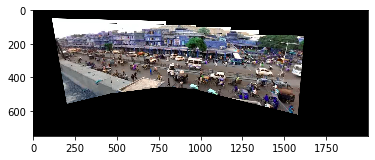

In [143]:
H_t = [[1,0,700],[0,1,100],[0,0,1]]
H_t2 = [[1,0,700],[0,1,100]]

img_90 = cv2.warpPerspective(im90, np.dot(H_t,H_90_450), (2000, 750))
img_270 = cv2.warpPerspective(im270, np.dot(H_t,H_270_450), (2000, 750))
img_450 = cv2.warpAffine(im450, np.float32(H_t2), (2000, 750))
img_630 = cv2.warpPerspective(im630, np.dot(H_t,H_630_450), (2000, 750))
img_810 = cv2.warpPerspective(im810, np.dot(H_t,H_810_450), (2000, 750))

# plt.figure()
# plt.imshow(img_90)

# plt.figure()
# plt.imshow(img_270)

# plt.figure()
# plt.imshow(img_450)

# plt.figure()
# plt.imshow(img_630)

# plt.figure()
# plt.imshow(img_810)

img_90 = np.float32(img_90/255.0)
img_270 = np.float32(img_270/255.0)
img_450 = np.float32(img_450/255.0)
img_630 = np.float32(img_630/255.0)
img_810 = np.float32(img_810/255.0)

canvas = np.zeros((img_90.shape))
for i in range(750):
    for j in range(2000):
#         if img_warped[i,j].any() and img_warped2[i,j].any():
#             canvas[i,j] = (img_warped[i,j]+img_warped2[i,j])/2
        if img_810[i,j].any():
            canvas[i,j] = img_810[i,j]
        elif img_630[i,j].any():
            canvas[i,j] = img_630[i,j]
        elif img_450[i,j].any():
            canvas[i,j] = img_450[i,j]
        elif img_270[i,j].any():
            canvas[i,j] = img_270[i,j]
        elif img_90[i,j].any():
            canvas[i,j] = img_90[i,j]

# img_out = cv2.cvtColor(canvas,cv2.COLOR_RGB2BGR)
plt.figure()
plt.imshow(canvas)

### Part 3: Map the video to the reference plane

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import floor

import utils

In [12]:
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

In [13]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [14]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)

In [28]:
# images location
im90 = './images/input/frames/f0090.jpg'
im270 = './images/input/frames/f0270.jpg'
im450 = './images/input/frames/f0450.jpg'
im630 = './images/input/frames/f0630.jpg'
im810 = './images/input/frames/f0810.jpg'

# Load an color image in grayscale
img90 = im90 = cv2.imread(im90)
img270 = im270 = cv2.imread(im270)
img450 = im450 = cv2.imread(im450)
img630 = im630 = cv2.imread(im630)
img810 = im810 = cv2.imread(im810)

H_270_450 = auto_homography(im270,im450, computeHomography)
H_630_450 = auto_homography(im630,im450, computeHomography)

H_90_270 = auto_homography(im90,im270, computeHomography)
H_810_630 = auto_homography(im810,im630, computeHomography)

H_90_450 = np.dot(H_90_270,H_270_450)
H_810_450 = np.dot(H_810_630,H_630_450)

H_t = [[1,0,750],[0,1,250],[0,0,1]]
H_t2 = [[1,0,750],[0,1,250]]

best score: 124.000000
best score: 98.000000
best score: 150.000000
best score: 77.000000


In [155]:
os.mkdir("warped_frames")

In [32]:
for idx, file_i in enumerate(filenames):
    img = cv2.imread(file_i)
    if idx < 90:
        H = auto_homography(img,img90, computeHomography)
        H = np.dot(H,H_90_450)
        warped = cv2.warpPerspective(img, np.dot(H_t,H), (2000, 850))
#         frames[idx] = warped
        cv2.imwrite("warped_frames/a{:04d}.jpg".format(idx), warped)
    elif (idx < 270) and (idx >= 90):
        H = auto_homography(img,img270, computeHomography)
        H = np.dot(H,H_270_450)
        warped = cv2.warpPerspective(img, np.dot(H_t,H), (2000, 850))
#         frames[idx] = warped
        cv2.imwrite("warped_frames/a{:04d}.jpg".format(idx), warped)
    elif (idx >= 270) and (idx <= 630):
        H = auto_homography(img,img450, computeHomography)
        warped = cv2.warpPerspective(img, np.dot(H_t,H), (2000, 850))
#         frames[idx] = warped
        cv2.imwrite("warped_frames/a{:04d}.jpg".format(idx), warped)
    elif (idx > 630) and (idx <= 810):
        H = auto_homography(img,img630, computeHomography)
        H = np.dot(H,H_630_450)
        warped = cv2.warpPerspective(img, np.dot(H_t,H), (2000, 850))
#         frames[idx] = warped
        cv2.imwrite("warped_frames/a{:04d}.jpg".format(idx), warped)
    elif idx > 810:
        H = auto_homography(img,img810, computeHomography)
        H = np.dot(H,H_810_450)
        warped = cv2.warpPerspective(img, np.dot(H_t,H), (2000, 850))
#         frames[idx] = warped
        cv2.imwrite("warped_frames/a{:04d}.jpg".format(idx), warped)

best score: 306.000000
best score: 285.000000
best score: 286.000000
best score: 279.000000
best score: 314.000000
best score: 319.000000
best score: 319.000000
best score: 321.000000
best score: 311.000000
best score: 353.000000
best score: 328.000000
best score: 295.000000
best score: 342.000000
best score: 338.000000
best score: 344.000000
best score: 354.000000
best score: 340.000000
best score: 342.000000
best score: 340.000000
best score: 343.000000
best score: 352.000000
best score: 343.000000
best score: 345.000000
best score: 336.000000
best score: 371.000000
best score: 342.000000
best score: 327.000000
best score: 361.000000
best score: 384.000000
best score: 354.000000
best score: 348.000000
best score: 361.000000
best score: 370.000000
best score: 343.000000
best score: 354.000000
best score: 372.000000
best score: 377.000000
best score: 324.000000
best score: 338.000000
best score: 368.000000
best score: 374.000000
best score: 380.000000
best score: 383.000000
best score:

best score: 130.000000
best score: 149.000000
best score: 134.000000
best score: 157.000000
best score: 166.000000
best score: 166.000000
best score: 176.000000
best score: 134.000000
best score: 140.000000
best score: 162.000000
best score: 136.000000
best score: 158.000000
best score: 169.000000
best score: 164.000000
best score: 183.000000
best score: 176.000000
best score: 170.000000
best score: 185.000000
best score: 172.000000
best score: 146.000000
best score: 192.000000
best score: 174.000000
best score: 146.000000
best score: 154.000000
best score: 164.000000
best score: 175.000000
best score: 157.000000
best score: 159.000000
best score: 156.000000
best score: 173.000000
best score: 178.000000
best score: 173.000000
best score: 185.000000
best score: 179.000000
best score: 180.000000
best score: 156.000000
best score: 180.000000
best score: 196.000000
best score: 196.000000
best score: 191.000000
best score: 154.000000
best score: 140.000000
best score: 162.000000
best score:

best score: 131.000000
best score: 109.000000
best score: 110.000000
best score: 101.000000
best score: 87.000000
best score: 109.000000
best score: 111.000000
best score: 112.000000
best score: 117.000000
best score: 110.000000
best score: 109.000000
best score: 94.000000
best score: 99.000000
best score: 102.000000
best score: 84.000000
best score: 99.000000
best score: 94.000000
best score: 90.000000
best score: 97.000000
best score: 110.000000
best score: 95.000000
best score: 102.000000
best score: 101.000000
best score: 98.000000
best score: 91.000000
best score: 98.000000
best score: 95.000000
best score: 87.000000
best score: 104.000000
best score: 93.000000
best score: 88.000000
best score: 95.000000
best score: 94.000000
best score: 103.000000
best score: 86.000000
best score: 87.000000
best score: 68.000000
best score: 87.000000
best score: 89.000000
best score: 77.000000
best score: 69.000000
best score: 79.000000
best score: 82.000000
best score: 88.000000
best score: 85.0

In [23]:
utils.imageFolder2mpeg('warped_frames', fps=30)

In [17]:
## Example usage of utils.projectImage

pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)
originTranslations = np.zeros((len(filenames), 2), dtype=np.float32)
sourceFrameIndex = 630
referenceFrameIndex = 450

In [ ]:
projectedSource, _, originTranslations = utils.projectImage(frames, sourceFrameIndex, referenceFrameIndex,
                                                            pastHomographies, originTranslations,
                                                            auto_H_func=auto_homography, homography_func=computeHomography)

In [ ]:
projectedReference, _, originTranslations = utils.projectImage(frames, referenceFrameIndex, referenceFrameIndex,
                                                               pastHomographies, originTranslations,
                                                               auto_H_func=auto_homography, homography_func=computeHomography)

In [25]:
blendedOutput = utils.blendImages(projectedSource, projectedReference)

In [ ]:
plt.imshow(blendedOutput)

### Part 4: Create background panorama

In this part you will remove moving objects from the video and create a background panorama that should incorporate pixels from all the frames.

In the video you produced in __part 3__ each pixel appears in several frames. You need to estimate which of the many colors correspond to the background. We take advantage of the fact that the background color is fixed while the foreground color changes frequently (because foreground moves).

<img src="images/project_5/background.jpg" alt="Drawing" style="float: center; width: 500px"/>


For each pixel in the sequence of __part 3__, determine all valid colors (colors that come from all frames that overlap that pixel). You can experiment with different methods for determining the background color of each pixel, as discussed in class. Perform the same procedure for all pixels and generate output. The output should be a completed panorama showing only pixels of background or non-moving objects.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Part 5: Create background movie

Map the background panorama to the movie coordinates. For each frame of the movie, say frame 1, you need to estimate a projection from the panorama to frame 1. Note, you should be able to re-use the homographies that you estimated in __Part 3__. Perform this for all frames and generate a movie that looks like the input movie but shows only background pixels. All moving objects that belong to the foreground must be removed.

In [ ]:
import os
import cv2
import numpy as np

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that only includes foreground pixels.

In [1]:
import os
import cv2
import numpy as np

## Bells and whistles